## Membrane-only

**Last executed:** Aug 9, 2021 with MDAnalysis 2.0.0b



**Packages required:** MDAnalysis, MDAnalysisTests


**Packages for visualization:** Matplotlib

In [1]:
import MDAnalysis as mda
from membrane_curvature.base import MembraneCurvature
from MDAnalysis.tests.datafiles import Martini_membrane_gro
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

        
%matplotlib inline

MDAnalysis  : INFO     MDAnalysis 2.0.0-dev0 STARTED logging to 'MDAnalysis.log'


### Loading the Universe

In this first example, we are going to perform membrane curvature calculation on a lipid bilayer of composition DPPC:CHOL using the Martini force field. 
This file is included in the [MDAnalysisTests](https://github.com/MDAnalysis/mdanalysis/wiki/UnitTests). 

We start by loading our molecular dynamics structure into a MDAnalysis Universe:

In [2]:
universe = mda.Universe(Martini_membrane_gro)

To visualize the system, we make use of the [NGL Viewer](https://github.com/nglviewer/nglview). 

In [3]:
import nglview as nv

def view_box(leaflet):
    view = nv.show_mdanalysis(leaflet)
    view.add_unitcell()
    view.camera='orthographic'
    view.control.zoom(-0.4)
    view.control.rotate(
         mda.lib.transformations.quaternion_from_euler(
             -np.pi/2, np.pi/3, np.pi/12, 'rzyz').tolist())
    return view

Typically in lipid bilayers, lipid headgroups are the most suitable `AtomGroup` to derive surfaces. 

Since our system comprises a bilayer, we should run MembraneCurvature for each leaflet in our ``Universe``.

### Selecting leaflets
To double-check we have the write selection, let's first check the atoms that belong to each leaflet.

#### Upper leaflet

In [4]:
upper_leaflet = universe.select_atoms('resid 1-225 and name PO4') 
view_box(upper_leaflet)

NGLWidget()

The AtomGroup associated to the upper leaflet looks like this:

<img src="assets/upper_lf.png" width="100" height="100" align='center'>

#### Lower leaflet

In [5]:
lower_leaflet = universe.select_atoms('resid 226-450 and name PO4')
view_box(lower_leaflet)

NGLWidget()

And for the lower leaflet, the selection looks like this:

<img src="assets/lower_lf.png" width="100" height="100" align='center'>

### Run MembraneCurvature


Now that we know the residues in each leaflet, we can calculate curvature for each AtomGroup of reference we have chosen. 

With MembraneCurvature, this can be done as follows:

In [6]:
curvature_upper_leaflet = MembraneCurvature(universe, 
                                            select='resid 1-225 and name PO4', 
                                            n_x_bins=8, 
                                            n_y_bins=8, 
                                            wrap=True).run()

MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


In [7]:
curvature_lower_leaflet = MembraneCurvature(universe, 
                                            select='resid 226-450 and name PO4', 
                                            n_x_bins=8, 
                                            n_y_bins=8, 
                                            wrap=True).run()

MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


### Extract the derived surface
In MembraneCurvature, the derived surface and calculated curvatures are available in the `results` attributes.

We can check the surface derived from the lipid headgroups in each leaflet with

In [8]:
surface_upper_leaflet = curvature_upper_leaflet.results.z_surface

In [9]:
surface_lower_leaflet = curvature_lower_leaflet.results.z_surface

Then, to visualize the obtained surfaces we can use [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).

We can plot doing something like this:



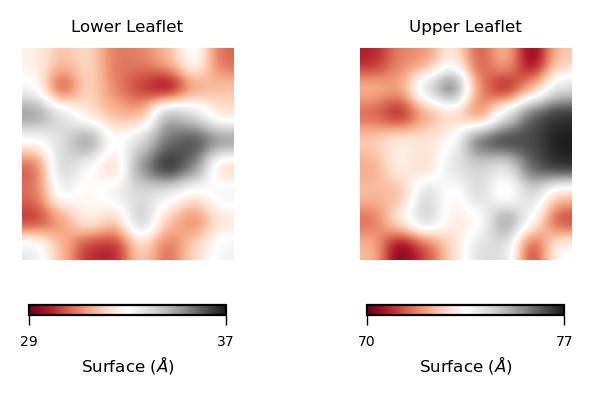

In [10]:
surfaces = [surface_lower_leaflet[0], surface_upper_leaflet[0]]

leaflets = ['Lower', 'Upper']


fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(4,2), dpi=200)
for ax, surfs, lf in zip((ax1, ax2), surfaces, leaflets):
    im = ax.imshow(surfs, interpolation='gaussian', cmap='RdGy', origin='lower')
    ax.set_aspect('equal')
    ax.set_title('{} Leaflet'.format(lf), fontsize=6)
    ax.axis('off')
    cbar = plt.colorbar(im, ticks=[surfs.min(), surfs.max()], orientation='horizontal', ax=ax, shrink=0.7)
    cbar.set_ticklabels([int(surfs.min()), int(surfs.max())])
    cbar.ax.tick_params(labelsize=5, width=0.5)
    cbar.set_label("Surface (${\AA}$)", fontsize=6, labelpad=2) 

We can define a function to plot each leaflet based on this plot. Then, our 

In [11]:
def plot_by_leaflet(results, label, cmap):
    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(4,2), dpi=200)
    for ax, rs, lf in zip((ax1, ax2), results, leaflets):
        im = ax.imshow(rs, interpolation='gaussian', cmap=cmap, origin='lower', alpha=0.8)
        ax.set_aspect('equal')
        ax.set_title('{} Leaflet'.format(lf), fontsize=6)
        ax.axis('off')
        cbar = plt.colorbar(im, ticks=[rs.min(), rs.max()], orientation='horizontal', ax=ax, shrink=0.7)
        cbar.ax.tick_params(labelsize=5, width=0.5)
        cbar.set_ticklabels([int(rs.min()), int(rs.max())])
        cbar.set_label(label, fontsize=6, labelpad=2) 
    return


Using the ``plot_byleaflet`` function, we can plot the surfaces as:

```
plot_by_leaflet(surfaces, "Surface (${\AA}$)", 'RdGy')
```
It will useful to plot our curvature results as well.

### Calculate curvature

The attributes `.results.average_mean_curvature` and
`results.average_gaussian_curvature` contain the computed
values of mean ($H$) and Gaussian ($K$) curvature averaged over the `n_frames` of the
trajectory.

---

**Note:**
Running MembraneCurvature analysis iterates over the trajectory provided in the Universe. In this particular example, our Universe was loaded with no trajectory. Therefore, the attributes `results.average_z_surface`, `results.average_mean`, and `results.average_gaussian` are the same as those calculated in the non averaged attributes: `results.z_surface`, `results.mean`, `results.gaussian`, respectively.

---

#### Mean Curvature ($H$)

To extract the calculated values of membrane curvature we  

In [12]:
mean_upper_leaflet = curvature_upper_leaflet.results.average_mean

In [13]:
mean_lower_leaflet = curvature_lower_leaflet.results.average_mean



Then, using a similar approach as for the :attr:`results.z_surface`, and our handy function `plot_by_leaflet`, we can plot the mean curvature associated to each leaflet

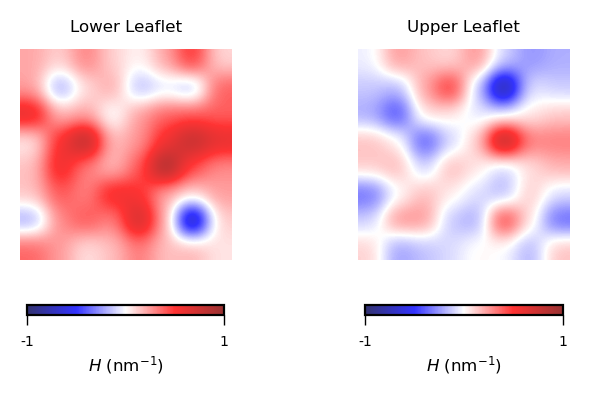

In [14]:
mean_curvs = [mean_lower_leaflet, mean_upper_leaflet]

plot_by_leaflet(mean_curvs, "$H$ (nm$^{-1}$)", "seismic")

#### Gaussian Curvature ($K$)

Since the information of the averaged Gaussian curvature is stored in the `results.average_gaussian` attribute, we can extract the values of $K$ by writing:

In [15]:
gaussian_upper_leaflet = curvature_upper_leaflet.results.average_gaussian

In [16]:
gaussian_lower_leaflet = curvature_lower_leaflet.results.average_gaussian

Now that we have values of $K$ by leaflet, stored in the variables `gaussian_upper_leaflet` and `mean_upper_leaflet`, we can plot the results using the funcion `plot_by_leaflet`.

In [17]:
gaussian_curvs = [gaussian_lower_leaflet, gaussian_upper_leaflet]

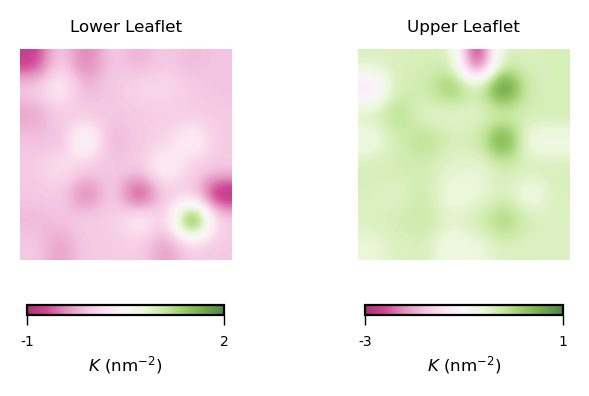

In [18]:
plot_by_leaflet(gaussian_curvs, "$K$ (nm$^{-2}$)", "PiYG")

#### Another way to plot: Contours

Another option to plot curvature obtained from the MembraneCurvature tool is by using `contourf`.

The function `plot_contours` as follows: 

In [19]:
from scipy import ndimage

def plot_contours(results, label, cmap):
    
    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(4,2), dpi=200)
    for ax, rs, lf in zip((ax1, ax2), results, leaflets):
        im = ax.contourf(ndimage.gaussian_filter(rs, sigma=1, order=0, mode='reflect'),
                         cmap=cmap, origin='lower', levels=40)
        ax.contour(ndimage.gaussian_filter(rs, sigma=1, order=0, mode='reflect'),
                         cmap=cmap, origin='lower', levels=40, linewidth=0.1)
        ax.set_aspect('equal')
        ax.set_title('{} Leaflet'.format(lf), fontsize=6)
        ax.axis('off')
        cbar = plt.colorbar(im, ticks=[rs.min(), rs.max()], orientation='horizontal', ax=ax, shrink=0.7)
        cbar.ax.tick_params(labelsize=5, width=0.5)
        cbar.set_ticklabels([int(rs.min()), int(rs.max())])
        cbar.set_label(label, fontsize=6, labelpad=2) 
    return

Then, we can produce `contour` plots for mean curvature with:

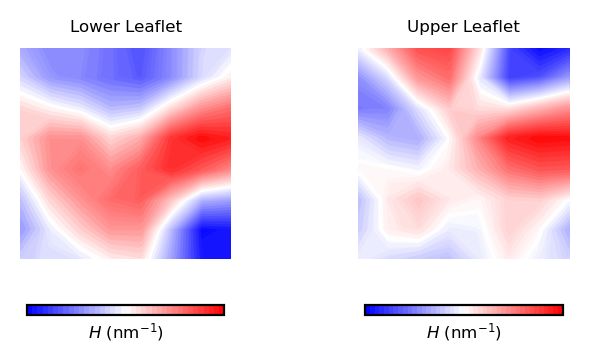

In [20]:
plot_contours(mean_curvs, "$H$ (nm$^{-1}$)", "bwr")

and the equivalent for Gaussian curvature with:

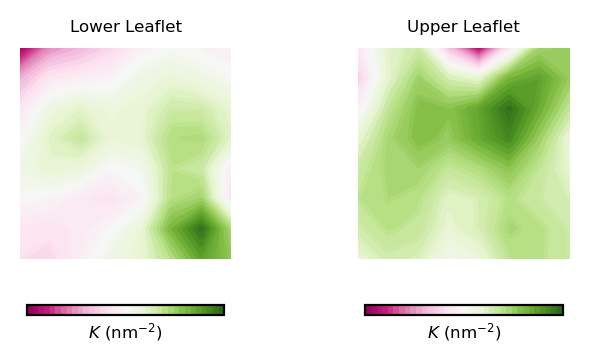

In [21]:
plot_contours(gaussian_curvs, "$K$ (nm$^{-2}$)", "PiYG")